In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the URL of the page to scrape
url = "https://www.the-numbers.com/movies/report/Concert-or-Performance/All/All/All/All/All/All/All/All/None/None/None/None/None/None/None/None/None/None?show-release-date=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On&view-order-by=domestic-box-office&view-order-direction=desc"

# Define a custom user agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"

# Create headers with the custom user agent
headers = {
    "User-Agent": user_agent
}

# Send a GET request to the URL with custom headers
response = requests.get(url, headers=headers)

In [2]:
# Parse the HTML content of the page
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the movie list
table = soup.find('table')

# Initialize empty lists to store movie data
movie_data = []

# Loop through each row in the table (skip the header row)
for row in table.find_all('tr')[1:]:
    columns = row.find_all('td')
    if len(columns) == 6:  # Ensure that the row has all the expected columns
        rank = columns[0].get_text(strip=True)
        release_date = columns[1].get_text(strip=True)
        title = columns[2].find('a').get_text(strip=True)
        url = columns[2].find('a').get('href')
        domestic_box_office = columns[3].get_text(strip=True)
        international_box_office = columns[4].get_text(strip=True)
        worldwide_box_office = columns[5].get_text(strip=True)
        movie_data.append([rank, release_date, title, url, domestic_box_office, international_box_office, worldwide_box_office])

# Create a DataFrame from the movie data
df = pd.DataFrame(movie_data, columns=["Rank", "Release Date", "Title", "URL", "Domestic Box Office", "International Box Office", "Worldwide Box Office"])

# Save the DataFrame to a CSV file
df.to_csv("movie_list.csv", index=False)



In [3]:
df.head()

,Rank,Release Date,Title,URL,Domestic Box Office,International Box Office,Worldwide Box Office
0,1,"Feb 11, 2011",Justin Bieber: Never Say Never,/movie/Justin-Bieber-Never-Say-Never#tab=summary,"$73,013,910","$26,020,215","$99,034,125"
1,2,"Feb 1, 2008",Hannah Montana and Miley Cyrus: Best …,/movie/Hannah-Montana-and-Miley-Cyrus-Best-of-...,"$65,281,781","$5,430,318","$70,712,099"
2,3,"Dec 18, 1987",Eddie Murphy Raw,/movie/Eddie-Murphy-Raw#tab=summary,"$50,504,655",$0,"$50,504,655"
3,4,"Oct 13, 2023",TAYLOR SWIFT | THE ERAS TOUR,/movie/Taylor-Swift-The-Eras-Tour-(2023)#tab=s...,"$39,000,000",$0,"$39,000,000"
4,5,"Aug 18, 2000",The Original Kings of Comedy,/movie/Original-Kings-of-Comedy-The#tab=summary,"$38,168,022","$68,316","$38,236,338"


In [6]:
def scrape_movie(url):
    movie_response = requests.get(f'https://www.the-numbers.com{url}', headers=headers)

    # Parse the HTML content of the page
    soup = BeautifulSoup(movie_response.text, 'html.parser')

    # Find the table with the specified selector
    tables = soup.select('#box_office_chart > table')
    table = tables[1]

    # Initialize empty lists to store table data
    table_data = []

    # Loop through each row in the table
    for row in table.find_all('tr'):
        columns = row.find_all('td')
        row_data = [col.get_text(strip=True) for col in columns][:3]

        if len(row_data) > 0 and row_data[1] != "P" and row_data[1] != "4":
            table_data.append(row_data)

    # Create a DataFrame from the table data
    df = pd.DataFrame(table_data, columns=['Date', 'Rank', 'Gross'])

    return df



In [ ]:
data = {}

In [8]:
for index, row in df.iterrows():
    if index > 29:
        print(index, row['Title'], row['URL'])
        data[row['Title']] = scrape_movie(row['URL'])

30 Neil Young: Heart of Gold /movie/Neil-Young-Heart-of-Gold#tab=summary
31 N'sync: Bigger than Live /movie/N-sync-Bigger-than-Live#tab=summary
32 The Met: Live in HD - Manon Lescaut /movie/Met-Live-in-HD-Manon-Lescaut#tab=summary
33 The Met: Live in HD - Madama Butterfly /movie/Met-Live-in-HD-Madama-Butterfly#tab=summary
34 Sarah Silverman: Jesus is Magic /movie/Sarah-Silverman-Jesus-is-Magic#tab=summary
35 Billie Eilish Live at the 02 — Exte… /movie/Billie-Eilish-Live-at-the-02-Extended-Cut-(2023)#tab=summary
36 I'm the One That I Want /movie/I-m-the-One-That-I-Want#tab=summary
37 Festival Express /movie/Festival-Express#tab=summary
38 The Met: Live in HD - Tannhauser /movie/Met-Live-in-HD-Tannhauser-The#tab=summary
39 Met Opera — Agrippina /movie/Met-Opera-Agrippina-(2020)#tab=summary
40 Notorious C.H.O. /movie/Notorious-C-H-O#tab=summary
41 All Access: Front Row. Backstage. Live! /movie/All-Access-Front-Row-Backstage-Live#tab=summary
42 The Beatles Get Back: The Rooftop Con… /movie

IndexError: list index out of range

In [10]:
clean_data = []

def dval(s):
    return float(s.replace("$", "").replace(",", ""))

for movie_name in data:
    if len(data[movie_name])>3:
        d1 = data[movie_name].iloc[0]['Gross']
        d2 = data[movie_name].iloc[1]['Gross']
        d3 = data[movie_name].iloc[2]['Gross']
        clean_data.append([movie_name, dval(d1), dval(d2), dval(d3)])

clean_data = [d for d in clean_data if (sum(d[1:]) / (d[1])) < 6]

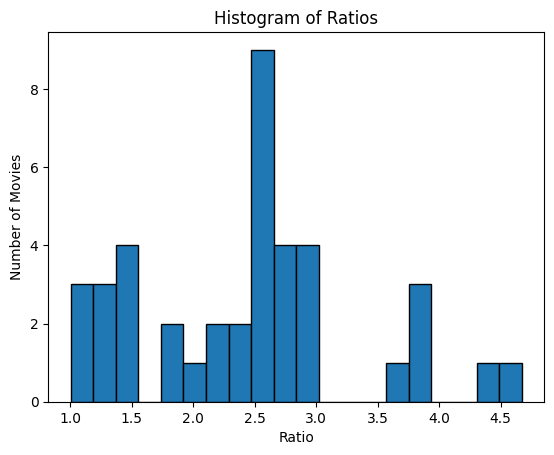

In [14]:
import matplotlib.pyplot as plt
# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Plot histogram
plt.hist(ratios, bins=20, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Number of Movies')
plt.title('Histogram of Ratios')
plt.show()


In [13]:
# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > 1.39)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


for movie in clean_data:
    if (sum(movie[1:]) / (movie[1] + movie[2])) > 1.39:
        print(movie[0])


The probability that the ratio exceeds 2.5 is 30.00%
Hannah Montana and Miley Cyrus: Best …
Kevin Hart: Let Me Explain
Katy Perry: Part of Me
Stop Making Sense
N'sync: Bigger than Live
Notorious C.H.O.
The Last Waltz
Aida at La Scala
Neil Young Journeys
La Traviata at La Scala
Inni
Contemporary Color


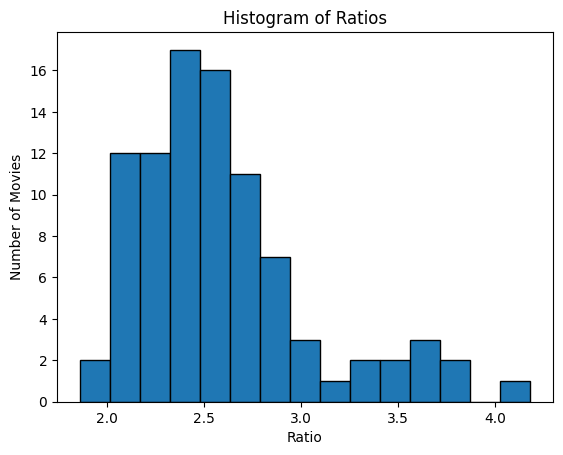

In [40]:
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Plot histogram
plt.hist(ratios, bins=15, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Number of Movies')
plt.title('Histogram of Ratios')
plt.show()


In [39]:
DAY_1_EARNINGS = 40 # mm

ratio_bound = 100/(DAY_1_EARNINGS)

# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > ratio_bound)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


The probability that the ratio exceeds 2.5 is 48.35%


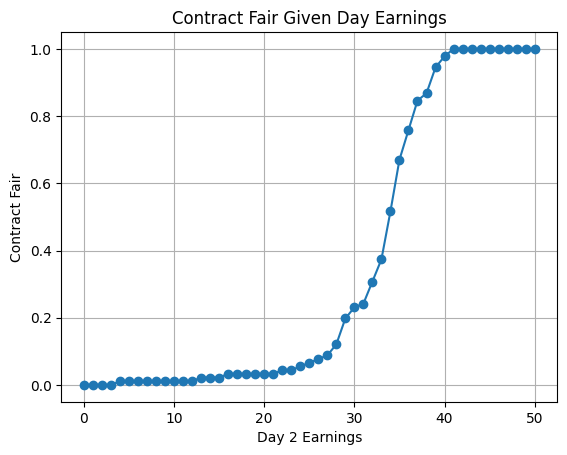

In [24]:

DAY_1_EARNINGS = 39  # mm

def calculate_probability(DAY_2_EARNINGS):
    ratio_bound = 100 / (DAY_1_EARNINGS + DAY_2_EARNINGS)
    ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]
    count_exceeding_bound = sum(1 for ratio in ratios if ratio > ratio_bound)
    return count_exceeding_bound / len(ratios)

# Get the probabilities for each value of DAY_2_EARNINGS from 0 to 50
probabilities = [calculate_probability(i) for i in range(51)]

# Plot
plt.plot(range(51), probabilities, marker='o', linestyle='-')
plt.xlabel('Day 2 Earnings')
plt.ylabel('Contract Fair')
plt.title('Contract Fair Given Day Earnings')
plt.grid(True)
plt.show()

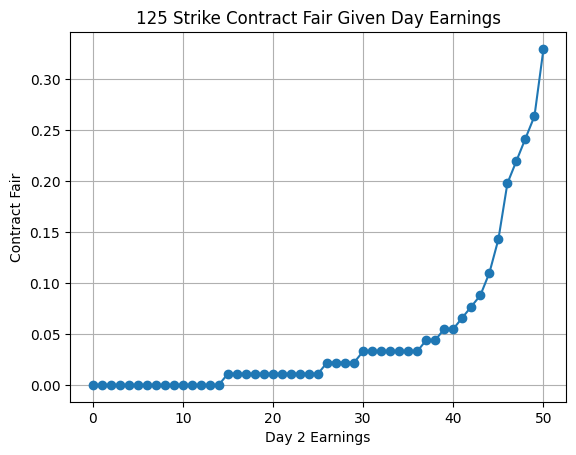

In [25]:

DAY_1_EARNINGS = 39  # mm

def calculate_probability(DAY_2_EARNINGS):
    ratio_bound = 125 / (DAY_1_EARNINGS + DAY_2_EARNINGS)
    ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]
    count_exceeding_bound = sum(1 for ratio in ratios if ratio > ratio_bound)
    return count_exceeding_bound / len(ratios)

# Get the probabilities for each value of DAY_2_EARNINGS from 0 to 50
probabilities = [calculate_probability(i) for i in range(51)]

# Plot
plt.plot(range(51), probabilities, marker='o', linestyle='-')
plt.xlabel('Day 2 Earnings')
plt.ylabel('Contract Fair')
plt.title('125 Strike Contract Fair Given Day Earnings')
plt.grid(True)
plt.show()

In [26]:
DAY_1_EARNINGS = 39

ratio_bound = 125/(DAY_1_EARNINGS)

# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > ratio_bound)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


The probability that the ratio exceeds 2.5 is 12.09%


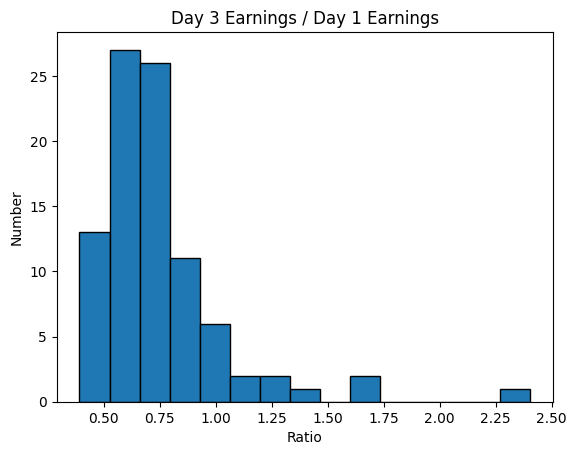

In [27]:
import matplotlib.pyplot as plt
# Compute ratios
ratios = [movie[3] / movie[1] for movie in clean_data]

# Plot histogram
plt.hist(ratios, bins=15, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Number')
plt.title('Day 3 Earnings / Day 1 Earnings')
plt.show()


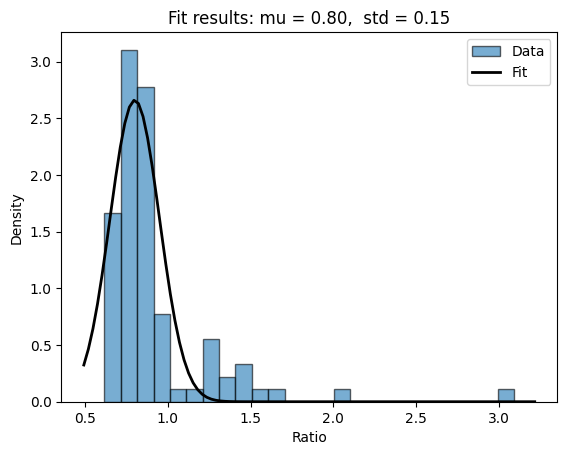

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming clean_data is already defined
ratios = [movie[3] / movie[2] for movie in clean_data]

# Estimate the parameters of the normal distribution
# mu, std = norm.fit(ratios)
mu = 0.8
std = 0.15

# Plot histogram
plt.hist(ratios, bins=25, edgecolor='black', density=True, alpha=0.6, label="Data")

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label="Fit")

# Set title and labels
plt.title(f"Fit results: mu = {mu:.2f},  std = {std:.2f}")
plt.xlabel('Ratio')
plt.ylabel('Density')
plt.legend()

plt.show()


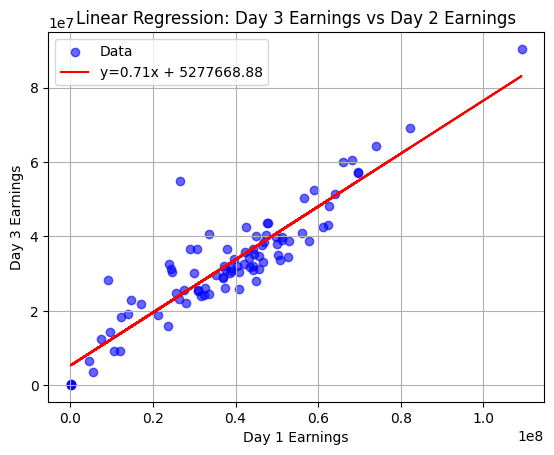

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming clean_data is already defined
day2_earnings = [movie[2] for movie in clean_data]
day3_earnings = [movie[3] for movie in clean_data]

# Linear regression
slope, intercept = np.polyfit(day2_earnings, day3_earnings, 1)

# Scatter plot
plt.scatter(day2_earnings, day3_earnings, label='Data', color='blue', alpha=0.6)

# Plot regression line
x = np.array(day2_earnings)
y = slope * x + intercept
plt.plot(x, y, color='red', label=f'y={slope:.2f}x + {intercept:.2f}')

# Set title and labels
plt.title('Linear Regression: Day 3 Earnings vs Day 2 Earnings')
plt.xlabel('Day 1 Earnings')
plt.ylabel('Day 3 Earnings')
plt.legend()
plt.grid(True)

plt.show()


In [31]:
from sklearn.linear_model import LinearRegression

# Assuming clean_data is already defined
day1_earnings = [movie[1] for movie in clean_data]
day2_earnings = [movie[2] for movie in clean_data]
day3_earnings = [movie[3] for movie in clean_data]

# Reshape the data and prepare the feature matrix X and target vector y
X = list(zip(day1_earnings, day2_earnings))
y = day3_earnings

# Create and fit the model
model = LinearRegression().fit(X, y)

# Print coefficients
print(f"a1 (coefficient for Day 1 Earnings): {model.coef_[0]:.2f}")
print(f"a2 (coefficient for Day 2 Earnings): {model.coef_[1]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")


a1 (coefficient for Day 1 Earnings): 0.13
a2 (coefficient for Day 2 Earnings): 0.53
Intercept: 5574401.80


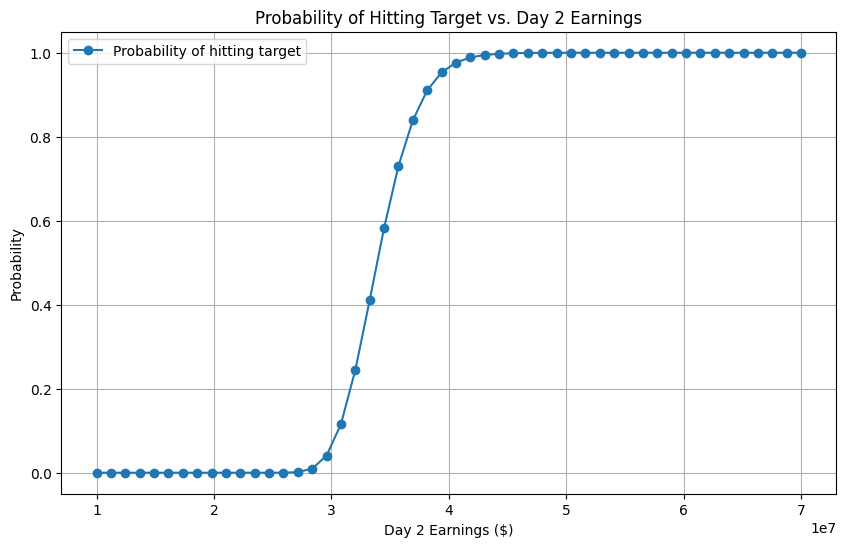

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def get_target(day_2_earnings):
    # target ratio day 3 / day 2 to hit 100mm
    target = (100e6 - 39e6 - day_2_earnings) / day_2_earnings
    return target

def prob_hitting_target(target):
    mu = 0.8
    sigma = 0.15
    return 1 - norm.cdf(target, mu, sigma)

x_vals = np.linspace(10000000, 70000000, 50)
y_vals = [prob_hitting_target(get_target(x)) for x in x_vals]

plt.figure(figsize=(10,6))
plt.plot(x_vals, y_vals, '-o', label='Probability of hitting target')
plt.xlabel('Day 2 Earnings ($)')
plt.ylabel('Probability')
plt.title('Probability of Hitting Target vs. Day 2 Earnings')
plt.legend()
plt.grid(True)
plt.show()
